# Project M2 (rename it)

First we import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style("darkgrid")
%matplotlib inline

#load the statistical libraries
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from ipywidgets import interact
from IPython.display import HTML,Javascript, display
from sklearn import preprocessing

## Data preprocessing
In this project, we will investigate in to two beer rating datasets, BeerAdvocate and RateBeer. Both datasets contain ```user```, ```brewery```, ```beeer``` and ```rating```.

##### Note of rating files
Since the **rating** files are txt files of about several gigabytes in size, we cannot handle it simultaneously. Therefore, we **sliced** them to several small pieces and then **combined** them into '.csv' files.

The slicing process is extremely time-consuming, thus we won't put the code here. The method is just parsing the file line by line and add some number restrictions for each bulk. And transfer the '.txt' file to '.csv' file.

We also filtered out the beer data which has less than 120 ratings. In this way each beer has enough rating for data analysis.**Add Why**

We put the processed rating data in the same directory as this ipython notebook and name them as **after_pro_data_ba.csv** and **after_pro_data_rb.csv** for **BeerAdvocate** and **RateBeer** respectively.

### Handle the missing value and initial data filtering

#### BeerAdvocate

In [2]:
# Load ratings data from BeerAdvocate
df_rating_ba = pd.read_csv('after_pro_data_ba.csv')
df_rating_ba = df_rating_ba.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_ba)} ratings on BeerAdvocate website')
df_rating_ba.head()

Currently, there are 247982 ratings on BeerAdvocate website


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True


In [3]:
# The scoring attribute
column_ = ['appearance', 'aroma', 'palate', 'taste', 'overall']
print(f'There are {df_rating_ba [column_].isna().any(axis = 1).value_counts()[1]} rows have NAN values in BeerAdvocate')
print(f'There are {np.sum(df_rating_ba [column_].isna().sum(axis = 1)==5)} rows with 5 NAN values in BeerAdvocate')
compare_ba = df_rating_ba[df_rating_ba[column_].isna().any(axis = 1)]
compare_ba['rating'].describe()

There are 94879 rows have NAN values in BeerAdvocate
There are 94879 rows with 5 NAN values in BeerAdvocate


count    94879.000000
mean         3.562944
std          0.804304
min          1.000000
25%          3.000000
50%          3.750000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

Here we found if there is no overall score, there wouldn't be detailed scores about one beer. We also check the website manually, and found that we should rate the appearance, aroma, palate, taste, overall together.
However, these data all have the rating values. We don't think that these data are useful since we want to find some relationship of the detailed score to the rating and other perspectives. And since we will still have very large amout data after deleting them, we will just simply delete them.

In [4]:
#Delete all meaninigless lines
df_rating_ba = df_rating_ba[~df_rating_ba[column_].isna().any(axis = 1)]
df_rating_ba.shape

(153103, 17)

The user_id in BeerAdvocate rating dataset are composed of both of name and id we want to keep the numeric id for simplicity.

In [5]:
#spilt the user_id in BeerAdvocate
def str_split(data):
    return data.split('.')[1]
df_rating_ba['user_id'] = df_rating_ba['user_id'].apply(str_split)
df_rating_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True


#### RateBeer
We will do the similar process to the RateBeer dataset.

In [7]:
# Load rating data on RateBeer website
df_rating_rb = pd.read_csv('after_pro_data_rb.csv')
df_rating_rb = df_rating_rb.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_rb)} ratings on RateBeer website')
df_rating_rb.head()

Currently, there are 396690 ratings on RateBeer website


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1451646000,fombe89,250510,4,3,1,2,5,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1445594400,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours l...


In [13]:
print(f"Thera are {df_rating_rb[column_].isna().any(axis = 1).value_counts()[0]} rows don't have NAN value")
print(f'Thera are {np.sum(df_rating_rb [column_].isna().sum(axis = 1)==5)} rows with NAN value')
compare_rb = df_rating_rb[df_rating_rb[column_].isna().any(axis = 1)]
print("Since we don't have nan values we won't do the missing values handling here.")

Thera are 396690 rows don't have NAN value
Thera are 0 rows with NAN value
Since we don't have nan values we won't do the missing values handling here.


### Datasets preparation and more filtering
#### BeerAdvocate
We first map the scale of each rating to 0-5 to make a consistency between the two datasets.

In [14]:
column_list = ['appearance', 'aroma', 'palate', 'taste', 'overall','rating']
list_value = df_rating_ba[column_list].values
min_max_scaler = preprocessing.MinMaxScaler()
list_value_scaler = min_max_scaler.fit_transform(list_value) * 5
data_temp_ba = pd.DataFrame(list_value_scaler,columns=column_list,index = df_rating_ba.index)
df_rating_ba[column_list] = data_temp_ba

df_rating_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,184925,2.8125,2.1875,2.8125,2.1875,2.500,2.3500,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,163714,2.5000,3.1250,3.1250,3.7500,3.125,3.3375,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,19527,3.7500,3.1250,3.1250,3.7500,3.125,3.4125,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,10867,3.7500,3.1250,3.7500,3.7500,4.375,3.7250,Serving,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,3708,3.7500,3.7500,3.7500,3.7500,3.750,3.7500,"500ml bottlePours with a light, slightly hazy ...",True


By doing some simple regression study we find there exist perfect linear relationship between 'overall', 'aroma', 'palate', 'taste', 'overall', 'rating'.

In [17]:
# Use linear regression to fit our data
mod_ba = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data = df_rating_ba)
res_ba = mod_ba.fit()
print(res_ba.summary())
print(f'The R-squared is 1.000 so it is of perfect linear relationship.')

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.509e+09
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:55:59   Log-Likelihood:             6.9712e+05
No. Observations:              151191   AIC:                        -1.394e+06
Df Residuals:                  151185   BIC:                        -1.394e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0011   2.84e-05     37.828      0.0

We also find that there exists some ratings that the **overall** score exceeds the average of the other 4 features(can do this due to the perfect linear relationship). We consider this situation as invalid ratings. Because in common sense, if the detailed features of a beer is good/bad the overall will not be bad/good. And we set the difference threshold to 1.5(in scale of 5).

In [15]:
df_rating_ba['average'] = df_rating_ba[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_ba['diff'] = np.abs(df_rating_ba['overall']-df_rating_ba['average'])
df_rating_ba = df_rating_ba[df_rating_ba['diff'] <1.5]
df_rating_ba = df_rating_ba.drop(columns=['average','diff'])
df_rating_ba.shape

(151191, 17)

In [18]:
# Load user data from BeerAdvocate
df_user_ba = pd.read_csv('BeerAdvocate/users.csv')
df_user_ba['user_id'] = df_user_ba['user_id'].apply(str_split)
df_user_ba.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,3708,cypressbob,1.069326e+09,Northern Ireland


In [19]:
# Load beer data from BeerAdvocate
df_beer_ba = pd.read_csv('BeerAdvocate/beers.csv')
df_beer_ba.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [20]:
# Load brewery data from BeerAdvocate
df_brewery_ba = pd.read_csv('BeerAdvocate/breweries.csv')
df_brewery_ba.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [21]:
# Merge data based on user id in order to get users' location
#user_region = df_user_ba[['user_id', 'location']]
region_ba = pd.merge(df_rating_ba, df_user_ba, how="left", left_on='user_id', right_on='user_id')

In [22]:
region_agg = region_ba[['location', 'beer_id']].groupby('location').agg('count')
region_agg = pd.DataFrame(region_agg.to_records())
region_agg.rename(columns={'beer_id':'count'}, inplace=True)
region_agg = region_agg.sort_values(by=['count'], ascending=False)
region_agg.reset_index(inplace=True, drop=True)
# Print top 20 region
region_agg.head(20)

,location,count
0,England,14843
1,Canada,12070
2,"United States, California",8621
3,"United States, New York",7868
4,"United States, Pennsylvania",7231
5,"United States, Massachusetts",5139
6,"United States, Illinois",4998
7,"United States, Texas",4919
8,"United States, Ohio",4281
9,"United States, Virginia",3419


#### RateBeer
First map to scale to 0-5 then filtered the invalid rating as previous steps

In [27]:
list_value_rb = df_rating_rb[column_list].values
list_value_scaler_rb = min_max_scaler.fit_transform(list_value_rb) * 5
data_temp_rb = pd.DataFrame(list_value_scaler_rb,columns=column_list,index = df_rating_rb.index)
df_rating_rb[column_list] = data_temp_rb

In [28]:
mod_rb = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data =df_rating_rb)
res_rb = mod_rb.fit()
print(res_rb.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.261e+29
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:02:39   Log-Likelihood:             1.0636e+07
No. Observations:              393134   AIC:                        -2.127e+07
Df Residuals:                  393128   BIC:                        -2.127e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.092e-12   2.45e-15    446.208      0.0

In [29]:
df_rating_rb['average'] = df_rating_rb[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_rb['diff'] = np.abs(df_rating_rb['overall']-df_rating_rb['average'])
df_rating_rb = df_rating_rb[df_rating_rb['diff'] <1.5]
df_rating_rb = df_rating_rb.drop(columns=['average','diff'])
df_rating_rb.shape

(393134, 16)

In [8]:
# Load brewery data on RateBeer website
df_brewery_rb = pd.read_csv('RateBeer/breweries.csv')
df_brewery_rb.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [9]:
# Load beer date on RateBeer website
df_beer_rb = pd.read_csv('RateBeer/beers.csv')
df_beer_rb.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN


In [10]:
# Load user date on RateBeer website
df_user_rb = pd.read_csv('RateBeer/users.csv')
df_user_rb.head()

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany


In [11]:
# Merge data based on user id in order to get users' location
region_rb = pd.merge(df_rating_rb, df_user_rb, how="left", left_on='user_id', right_on='user_id')
region_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name_x,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_ratings,user_name_y,joined,location
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",1890,Manslow,1.337508e+09,Poland
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...,89,MAGICuenca91,1.484046e+09,Spain
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni...",169,Sibarh,1.384600e+09,Poland
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1451646000,fombe89,250510,4,3,1,2,5,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C...",3371,fombe89,1.363950e+09,Spain
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1445594400,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours l...,13043,kevnic2008,1.296644e+09,Germany


## Data Analysis and visualization
In this section we will explore more of the datasets we prepared above, and visualize them.

#### Overall Rating Distribution of the two website

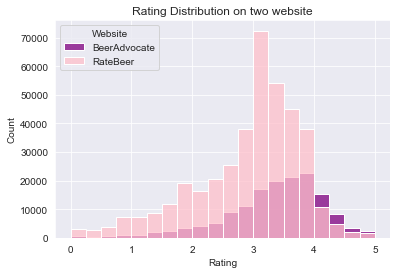

In [30]:
#creating subplots
ax=plt.subplots()

#plotting columns
ax=sns.histplot(data=df_rating_ba, x='rating', color = 'purple', binwidth=0.25, label='x')
ax=sns.histplot(data=df_rating_rb, x='rating', color = 'pink', binwidth=0.25)

# setting figure legend
plt.legend(title='Website', loc='upper left', labels=['BeerAdvocate', 'RateBeer'])

#renaming the axes
ax.set(xlabel="Rating", ylabel="Count")

# setting figute title
ax.set_title("Rating Distribution on two website")

# visualizing illustration
plt.show()

We can see that in this plot, rating on both websites are distributed like a normal distribution. There concentration of **rating** between 3-4 contributes to the majority.

#### Rating Distribution of Brewery
##### BeerAdvocate

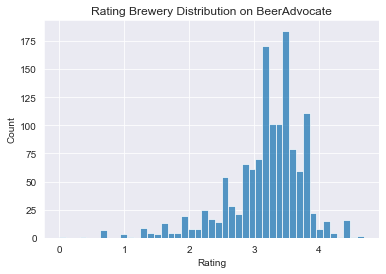

In [35]:
# explore ratings on each brewery
rating_brewery = pd.merge(df_rating_ba, df_brewery_ba, how='left', left_on='brewery_id', right_on='id')
rating_brewery = rating_brewery[['overall', 'brewery_name']]
mean_rating_brewery = rating_brewery.groupby('brewery_name').mean()
mean_rating_brewery = pd.DataFrame(mean_rating_brewery.to_records())

# draw rating brewery distribution
sns.histplot(data=mean_rating_brewery, x='overall')
plt.xlabel('Rating')
plt.title('Rating Brewery Distribution on BeerAdvocate')
plt.show()

##### RateBeer

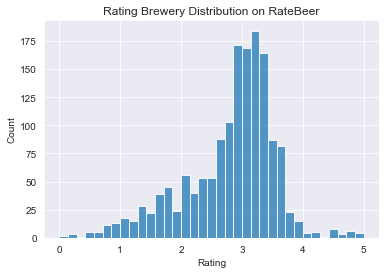

In [36]:
# explore ratings on each brewery
rating_brewery_rb = pd.merge(df_rating_rb, df_brewery_rb, how='left', left_on='brewery_id', right_on='id')
rating_brewery_rb = rating_brewery_rb[['overall', 'brewery_name']]
mean_rating_brewery_rb = rating_brewery_rb.groupby('brewery_name').mean()
mean_rating_brewery_rb = pd.DataFrame(mean_rating_brewery_rb.to_records())

# draw rating brewery distribution
sns.histplot(data=mean_rating_brewery_rb, x='overall')
plt.xlabel('Rating')
plt.title('Rating Brewery Distribution on RateBeer')
plt.show()

#### Rating Distribution of the detailed scores

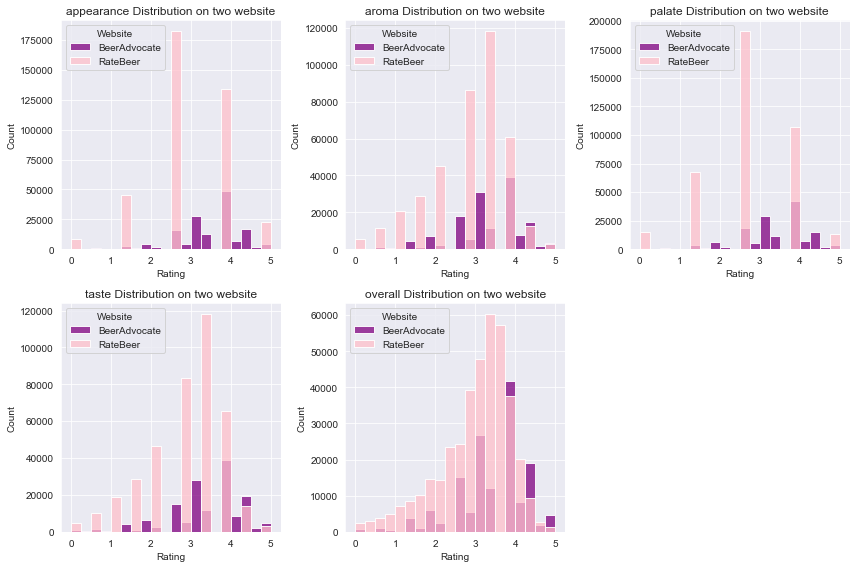

In [33]:
data_title = ['appearance', 'aroma','palate','taste','overall']
plt.figure(figsize=(12,8))


for index, i in enumerate(data_title):

    #creating subplots
    ax=plt.subplot(2,3,index+1)

    #plotting columns
    ax=sns.histplot(data=df_rating_ba, x=i, color = 'purple', binwidth=0.25, label='x')
    ax=sns.histplot(data=df_rating_rb, x=i, color = 'pink', binwidth=0.25)

    # setting figure legend
    plt.legend(title='Website', loc='upper left', labels=['BeerAdvocate', 'RateBeer'])

    #renaming the axes
    ax.set(xlabel="Rating", ylabel="Count")

    # setting figute title
    ax.set_title(f"{i} Distribution on two website")

    # visualizing illustration
plt.tight_layout()
plt.show()

#### The abv rankings on the two datasets

The average abv% of beers from BeerAdvocate is 5.95%.


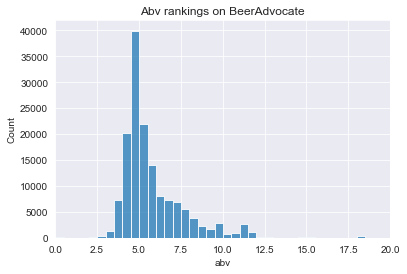

In [50]:
avg_ba_abv = region_ba.abv.mean()
avg_ba_abv = round(avg_ba_abv, 2)
print(f'The average abv% of beers from BeerAdvocate is {avg_ba_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_ba.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on BeerAdvocate")
plt.show()

The average abv% of beers from RateBeer is 6.18%.


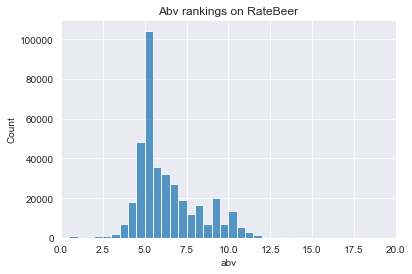

In [51]:
avg_rb_abv = region_rb.abv.mean()
avg_rb_abv = round(avg_rb_abv, 2)
print(f'The average abv% of beers from RateBeer is {avg_rb_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_rb.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on RateBeer")
plt.show()

#### (Interactive) Find the popular beers in top 10 regions with the largest number of users in each year.
##### BeerAdvocate

In [45]:
region_ba_style_change = region_ba[['date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'nbr_reviews', 'text', 'style']]

In [46]:
region_ba_style_change['formal_date'] = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))

/var/folders/xr/dbxcvdh15j9fxwy531k32mp00000gn/T/ipykernel_85165/240012875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_ba_style_change['formal_date'] = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))


In [47]:
region_ba_style_change = region_ba_style_change[['formal_date', 'date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'nbr_reviews', 'text', 'style']]

In [48]:
region_ba_style_change.formal_date.describe(datetime_is_numeric=True)

count                           151213
mean     2011-11-17 11:09:31.688941824
min                1998-01-22 12:00:00
25%                2008-10-12 12:00:00
50%                2012-03-22 12:00:00
75%                2015-08-05 12:00:00
max                2017-07-25 12:00:00
Name: formal_date, dtype: object

In [49]:
region_ba_style_change.sort_values('formal_date', inplace=True)
region_ba_style_change['year'] = region_ba_style_change.formal_date.apply(lambda x: x.year)
region_list = region_agg.location.to_list()
year_list = region_ba_style_change.year.unique()
region_list = region_list[:10]

In [50]:
# since there may have insufficient in early years, we want to make an alert in the interactive graph
def popup(text):
    display(HTML("<script>alert('{}');</script>".format(text)))

In [51]:
def plot_interactive(region, year):
    data_to_plot = region_ba_style_change[(region_ba_style_change.location==region) & (region_ba_style_change.year==year)][['brewery_name', 'style', 'beer_name','overall']]
    data_to_plot = data_to_plot.groupby('style').mean().reset_index()
    data_to_plot = data_to_plot.sort_values('overall', ascending=False).head(10)
    if len(data_to_plot) > 0:
        sns.barplot(y='style', x='overall', data=data_to_plot, palette="magma")
        plt.title(f'10 beer styles in {region} that are the most popular in year {year}.')
        plt.xlabel('Overall score')
        plt.ylabel('Beer style')
        plt.show()
    else:
        popup(f"Insufficient data for {region} in {year}.")


interact(plot_interactive, region=region_list, year=year_list[:])
# There are enough data from year 2003

interactive(children=(Dropdown(description='region', options=('England', 'Canada', 'United States, California'…

<function __main__.plot_interactive(region, year)>

##### Ratebeer

In [52]:
region_rb_style_change = region_rb[['date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'text', 'style']]

In [53]:
region_rb_style_change['formal_date'] = region_rb_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))

/var/folders/xr/dbxcvdh15j9fxwy531k32mp00000gn/T/ipykernel_85165/3627053753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_rb_style_change['formal_date'] = region_rb_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))


In [54]:
region_rb_style_change = region_rb_style_change[['formal_date', 'date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'text', 'style']]

In [55]:
region_rb_style_change.formal_date.describe(datetime_is_numeric=True)

count                           396854
mean     2012-02-17 21:58:20.106336768
min                2000-04-26 12:00:00
25%                2009-03-11 12:00:00
50%                2013-03-09 12:00:00
75%                2015-07-04 12:00:00
max                2017-07-25 12:00:00
Name: formal_date, dtype: object

In [57]:
region_rb_style_change.sort_values('formal_date', inplace=True)
region_rb_style_change['year'] = region_rb_style_change.formal_date.apply(lambda x: x.year)
region_list = region_agg.location.to_list()
year_list = region_rb_style_change.year.unique()
region_list = region_list[:10]

In [58]:
def plot_interactive(region, year):
    data_to_plot = region_rb_style_change[(region_rb_style_change.location==region) & (region_rb_style_change.year==year)][['brewery_name', 'style', 'beer_name','overall']]
    data_to_plot = data_to_plot.groupby('style').mean().reset_index()
    data_to_plot = data_to_plot.sort_values('overall', ascending=False).head(10)
    if len(data_to_plot) > 0:
        sns.barplot(y='style', x='overall', data=data_to_plot, palette="magma")
        plt.title(f'10 beer styles in {region} that are the most popular in year {year}.')
        plt.xlabel('Overall score')
        plt.ylabel('Beer style')
        plt.show()
    else:
        popup(f"Insufficient data for {region} in {year}.")


interact(plot_interactive, region=region_list, year=year_list[:])

interactive(children=(Dropdown(description='region', options=('England', 'Canada', 'United States, California'…

<function __main__.plot_interactive(region, year)>

#### Find the change of number of ratings
##### (interactive) Of each style of beers
###### BeerAdvocate

In [59]:
beer_style_list = region_ba_style_change['style'].groupby(region_ba_style_change['style']).agg('count')
beer_style_list.sort_values(ascending=False)
beer_style_list = np.array(beer_style_list.index.to_list())

In [60]:
def plot_year_vs_no_ratings_interactive(style):
    specific_style = style
    specific_style_region_by = region_ba_style_change[region_ba_style_change['style']==specific_style]
    specific_style_region_by = specific_style_region_by.dropna(how='any')
    specific_style_region_by = specific_style_region_by.drop_duplicates('year')
    sns.lineplot(data=specific_style_region_by, x='year', y='nbr_ratings')
    plt.title(f'The number of ratings of {style}')
    plt.xlabel('Year')
    plt.ylabel('Number of ratings')
    plt.show()

interact(plot_year_vs_no_ratings_interactive, style=beer_style_list)

interactive(children=(Dropdown(description='style', options=('Altbier', 'American Adjunct Lager', 'American Am…

<function __main__.plot_year_vs_no_ratings_interactive(style)>

###### RateBeer

In [61]:
beer_style_list_rb = region_rb_style_change['style'].groupby(region_rb_style_change['style']).agg('count')
beer_style_list_rb.sort_values(ascending=False)
beer_style_list_rb = np.array(beer_style_list_rb.index.to_list())

In [62]:
def plot_year_vs_no_ratings_interactive(style):
    specific_style = style
    specific_style_region_by = region_ba_style_change[region_rb_style_change['style']==specific_style]
    specific_style_region_by = specific_style_region_by.dropna(how='any')
    specific_style_region_by = specific_style_region_by.drop_duplicates('year')
    sns.lineplot(data=specific_style_region_by, x='year', y='nbr_ratings')
    plt.title(f'The number of ratings of {style}')
    plt.xlabel('Year')
    plt.ylabel('Number of ratings')
    plt.show()

interact(plot_year_vs_no_ratings_interactive, style=beer_style_list_rb)

interactive(children=(Dropdown(description='style', options=('Abbey Dubbel', 'Abbey Tripel', 'Abt/Quadrupel', …

<function __main__.plot_year_vs_no_ratings_interactive(style)>

##### Total number of ratings on the websites
###### BeerAdvocate

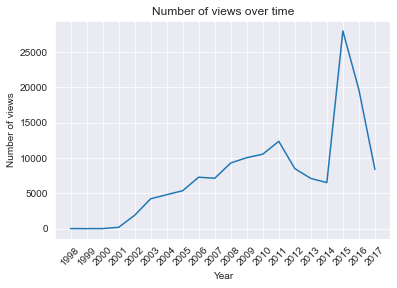

In [63]:
plt.plot(region_ba_style_change.groupby(['year']).count()['formal_date'].index, region_ba_style_change.groupby(['year']).count()['formal_date'])
plt.ylabel('Number of views')
plt.xlabel('Year')
plt.title('Number of views over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

According the image above, the number of views are increase over time. In 2014, it has the largest number of reviews. But after that, the number of views are keep decreasing. It can be noted that the number of evaluations suddenly doubled before 2013 and 2014, but it is not possible to analyse what caused this.

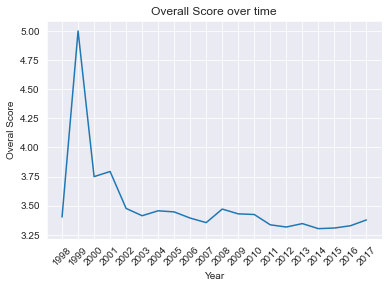

In [66]:
plt.plot(region_ba_style_change.groupby(['year']).mean()['overall'].index, region_ba_style_change.groupby(['year']).mean()['overall'])
plt.ylabel('Overal Score')
plt.xlabel('Year')
plt.title('Overall Score over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

It is easy to notice it has very high overall score in 1999. But after analysis the data, we notice it only have one review in 1999, so it make a illusion that sudden rise in ratings.

###### Ratebeer

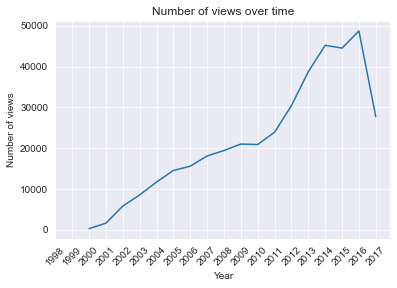

In [67]:
plt.plot(region_rb_style_change.groupby(['year']).count()['formal_date'].index, region_rb_style_change.groupby(['year']).count()['formal_date'])
plt.ylabel('Number of views')
plt.xlabel('Year')
plt.title('Number of views over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

The number of views are keep increase until 2016.

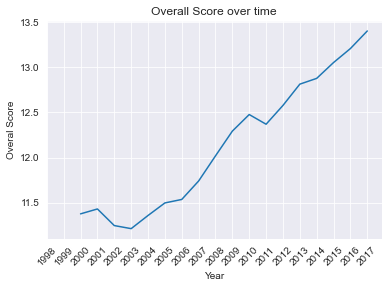

In [69]:
plt.plot(region_rb_style_change.groupby(['year']).mean()['overall'].index, region_rb_style_change.groupby(['year']).mean()['overall'])
plt.ylabel('Overal Score')
plt.xlabel('Year')
plt.title('Overall Score over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

The overall score are keep increasing. In 2017 it was almost 2 points higher than the year of 2000.